In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as linear_model
import seaborn as sns

In [8]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20
train_file_path = '/home/matheus/PycharmProjects/HousePrices/data/train.csv'
test_file_path = '/home/matheus/PycharmProjects/HousePrices/data/test.csv'
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)
test1 = pd.read_csv(test_file_path)

all_data = pd.concat([train, test], sort = False)

In [9]:
change_to_none = ["Alley", "MasVnrType","MiscFeature"]
change_to_no = ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
                "FireplaceQu", "GarageType","PoolQC","Fence"]
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)
all_data.loc[:,change_to_none] = all_data.loc[:,change_to_none].fillna("None")
all_data.loc[:,change_to_no] = all_data.loc[:,change_to_no].fillna("No") 

In [10]:
all_data = all_data.fillna(test.mean())
all_data.columns[all_data.isna().any()].tolist()
all_data = pd.get_dummies(all_data)

In [11]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:all_data.shape[0], :]
test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.000000,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.000000,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.000000,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.000000,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.000000,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0
5,1466,60,75.000000,10000,6,5,1993,1994,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
6,1467,20,68.580357,7980,6,7,1992,2007,0.0,935.0,...,0,0,0,1,0,0,0,0,1,0
7,1468,60,63.000000,8402,6,5,1998,1998,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
8,1469,20,85.000000,10176,7,5,1990,1990,0.0,637.0,...,0,0,0,1,0,0,0,0,1,0
9,1470,20,70.000000,8400,4,5,1970,1970,0.0,804.0,...,0,0,0,1,0,0,0,0,1,0


In [12]:
def list_corr(var="SalePrice", ascend=True):
    corr_m = train.corr().sort_values(var,ascending=ascend)
    return corr_m[var]

In [13]:
corr = list_corr()

positive = corr.where(corr>0.4).dropna().keys()

negative = corr.where(corr<-0.3).dropna().keys()
features = positive.union(negative)
features

Index(['1stFlrSF', 'BsmtExposure_No', 'BsmtFinType1_GLQ', 'BsmtQual_Ex',
       'BsmtQual_TA', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
       'FireplaceQu_No', 'Fireplaces', 'Foundation_CBlock', 'Foundation_PConc',
       'FullBath', 'GarageArea', 'GarageCars', 'GarageFinish_Fin',
       'GarageFinish_Unf', 'GarageType_Detchd', 'GarageYrBlt', 'GrLivArea',
       'HeatingQC_Ex', 'HeatingQC_TA', 'KitchenQual_Ex', 'KitchenQual_TA',
       'MasVnrArea', 'MasVnrType_None', 'Neighborhood_NridgHt', 'OverallQual',
       'SalePrice', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')

In [14]:
def matriz_corr(features):
    #correlation matrix
    corrmat = train[features].corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True);

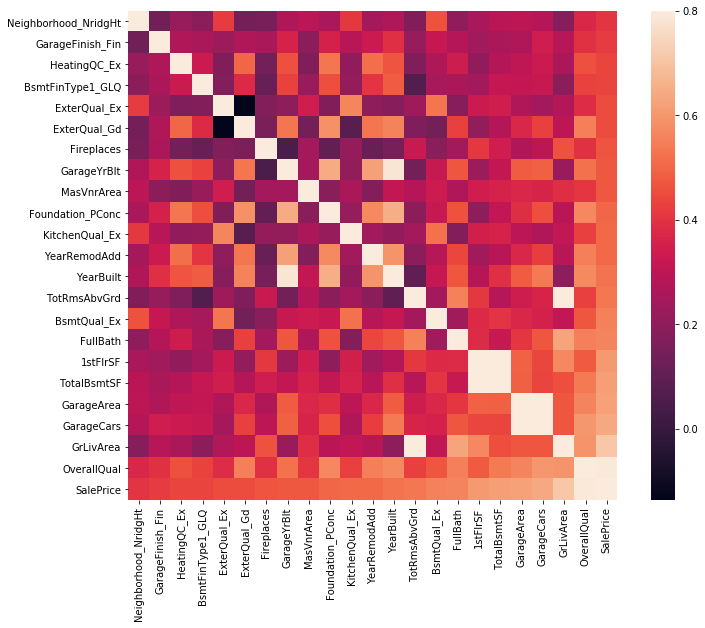

In [15]:
matriz_corr(positive)

In [16]:
list_corr(var='Foundation_PConc',ascend=False)

Foundation_PConc         1.000000
YearBuilt                0.651199
GarageYrBlt              0.646364
ExterQual_Gd             0.586748
YearRemodAdd             0.569728
OverallQual              0.568211
Exterior1st_VinylSd      0.562049
Exterior2nd_VinylSd      0.561608
HeatingQC_Ex             0.531246
SalePrice                0.497734
BsmtQual_Gd              0.494316
KitchenQual_Gd           0.479072
FullBath                 0.461667
BsmtFinType1_GLQ         0.453762
GarageCars               0.453421
GarageArea               0.388871
GarageFinish_Fin         0.354609
SaleType_New             0.328524
SaleCondition_Partial    0.323299
BsmtQual_Ex              0.321970
TotalBsmtSF              0.307701
GrLivArea                0.292764
Neighborhood_CollgCr     0.283952
Neighborhood_Somerst     0.280446
HouseStyle_2Story        0.265978
GarageType_Attchd        0.259788
BsmtUnfSF                0.258687
Neighborhood_NridgHt     0.258332
Fence_No                 0.257148
MasVnrType_Sto

In [17]:
features_to_drop = ["GarageArea","1stFlrSF","TotRmsAbvGrd","GarageYrBlt"]
features = positive.drop(features_to_drop)

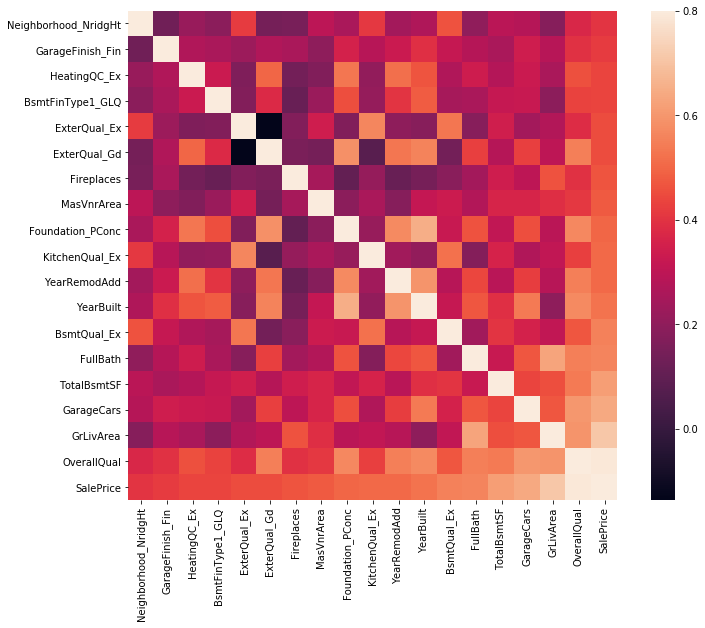

In [88]:
matriz_corr(features)

In [96]:
train = train.loc[:, features]

test = test.loc[:, features]
train

,Neighborhood_NridgHt,GarageFinish_Fin,HeatingQC_Ex,BsmtFinType1_GLQ,ExterQual_Ex,ExterQual_Gd,Fireplaces,MasVnrArea,Foundation_PConc,KitchenQual_Ex,YearRemodAdd,YearBuilt,BsmtQual_Ex,FullBath,TotalBsmtSF,GarageCars,GrLivArea,OverallQual,SalePrice
0,0,0,1,1,0,1,0,196.000000,1,0,2003,2003,0,2,856.0,2.0,1710,7,208500.0
1,0,0,1,0,0,0,1,0.000000,0,0,1976,1976,0,2,1262.0,2.0,1262,6,181500.0
2,0,0,1,1,0,1,1,162.000000,1,0,2002,2001,0,2,920.0,2.0,1786,7,223500.0
3,0,0,0,0,0,0,1,0.000000,0,0,1970,1915,0,1,756.0,3.0,1717,7,140000.0
4,0,0,1,1,0,1,1,350.000000,1,0,2000,2000,0,2,1145.0,3.0,2198,8,250000.0
5,0,0,1,1,0,0,0,0.000000,0,0,1995,1993,0,1,796.0,2.0,1362,5,143000.0
6,0,0,1,1,0,1,1,186.000000,1,0,2005,2004,1,2,1686.0,2.0,1694,8,307000.0
7,0,0,1,0,0,0,2,240.000000,0,0,1973,1973,0,2,1107.0,2.0,2090,7,200000.0
8,0,0,0,0,0,0,2,0.000000,0,0,1950,1931,0,2,952.0,2.0,1774,7,129900.0
9,0,0,1,1,0,0,2,0.000000,0,0,1950,1939,0,1,991.0,1.0,1077,5,118000.0


In [91]:
train.columns

Index(['Neighborhood_NridgHt', 'GarageFinish_Fin', 'HeatingQC_Ex',
       'BsmtFinType1_GLQ', 'ExterQual_Ex', 'ExterQual_Gd', 'Fireplaces',
       'MasVnrArea', 'Foundation_PConc', 'KitchenQual_Ex', 'YearRemodAdd',
       'YearBuilt', 'BsmtQual_Ex', 'FullBath', 'TotalBsmtSF', 'GarageCars',
       'GrLivArea', 'OverallQual', 'SalePrice'],
      dtype='object')

In [130]:
train['YearBuilt'] = train['YearBuilt']**2
list_corr()

YearBuilt               0.006266
Neighborhood_NridgHt    0.402149
GarageFinish_Fin        0.419678
HeatingQC_Ex            0.434543
BsmtFinType1_GLQ        0.434597
ExterQual_Ex            0.451164
ExterQual_Gd            0.452466
Fireplaces              0.466929
MasVnrArea              0.475178
TotalBsmtSF             0.479082
Foundation_PConc        0.497734
KitchenQual_Ex          0.504094
YearRemodAdd            0.507101
BsmtQual_Ex             0.553105
FullBath                0.560664
GarageCars              0.640409
GrLivArea               0.708624
OverallQual             0.790982
SalePrice               1.000000
Name: SalePrice, dtype: float64

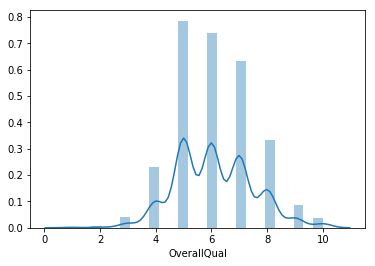

In [103]:
sns.distplot(train["OverallQual"]) 

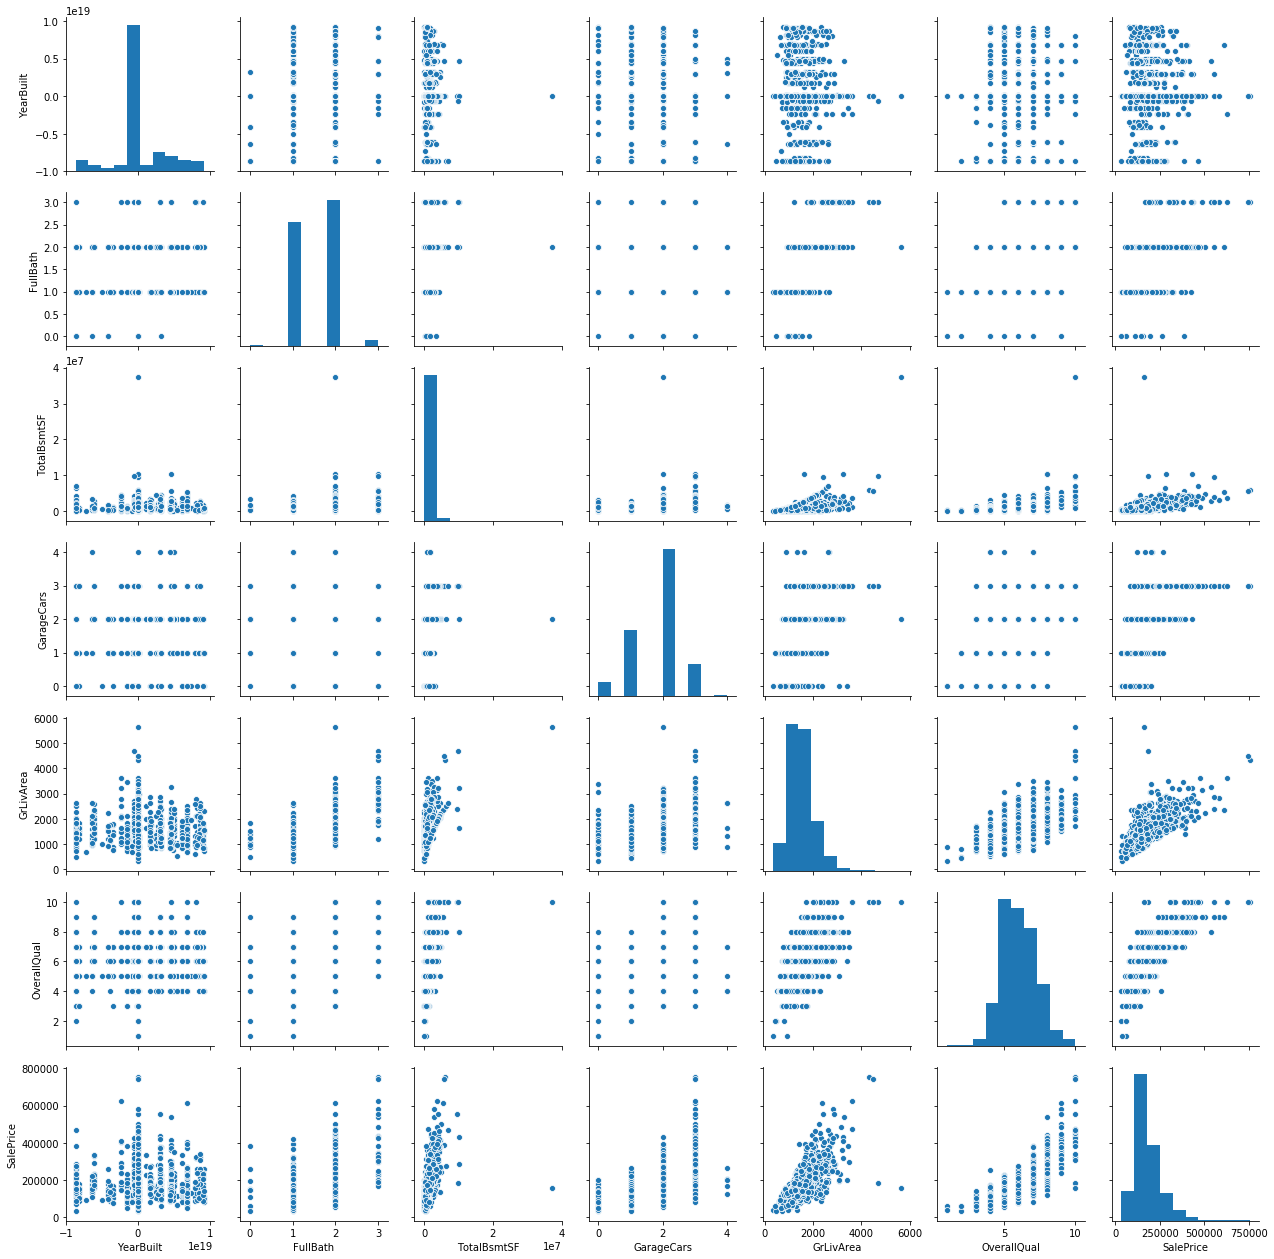

In [131]:
cols = ['YearBuilt', 'FullBath', 'TotalBsmtSF', 'GarageCars',
       'GrLivArea', 'OverallQual','SalePrice']
sns.pairplot(train[cols], height = 2.5)